### 載入所需的Libraries

In [75]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [124]:
# read data from spam.csv

###<your code>###
sms_data = pd.read_csv("spam.csv", encoding="iso-8859-1", usecols=["v1", "v2"])
sms_data.columns = ['label', "content"]
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [125]:
# check how many spams and hams
###<your code>###
sms_data.groupby("label").count()

,content
label,
ham,4825
spam,747


In [126]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data["label"]=sms_data["label"].replace(["ham"], "0")
sms_data["label"]=sms_data["label"].replace(["spam"], "1")
###<your code>###
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [132]:
# use stratify to preserve relative class frequencies when splitting data
sms_train, sms_test = train_test_split(sms_data, test_size = 0.2, stratify = sms_data.label)
sms_train.reset_index(inplace=True, drop=True)
sms_test.reset_index(inplace=True, drop=True)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        df.lowercase()

        # remove all punctuations
        ###<your code>###
        punctuation_list = ['.', ',', '!', '?']
        for pun in punctuation_list:
            df = df.replace(pun, ' ')
        df = df.split(' ')
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Train:
  label                                            content
0     0  mmmmm it was sooooo good to wake to your words...
1     0                    how much did ur hdd casing cost
2     0  total disappointment when i texted you was the...
3     0  wen ur lovable bcums angry wid u dnt take it s...
4     0                    i will spoil you in bed as well
Test:
  label                                            content
0     0  i sent you the prices and do you mean the lt gt g
1     0   havent still waitin as usual come back sch oredi
2     0               why tired what special there you had
3     0  my painful personal thought i always try to ke...
4     0                            hurry home soup is done


In [133]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
      df["content"][i] =  df["content"][i].lower()
    
      df['content'][i] =  re.sub(r"[\W]", " ", df['content'][i])
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Train:
  label                                            content
0     0  love isn t a decision  it s a feeling  if we c...
1     0                           yup    how ì_ noe leh   
2     0                     no chikku nt yet   ya i m free
3     0         normally i use to drink more water daily  
4     0  just chill for another 6hrs  if you could slee...
Test:
  label                                            content
0     1  u have a secret admirer who is looking 2 make ...
1     0                     hi what you think about match 
2     0  yup    ok i go home look at the timings then i...
3     0  how long has it been since you screamed  princ...
4     0  still in the area of the restaurant  ill try t...


In [135]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

8713

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [138]:
###<your code>###
vectorizer  =  TfidfVectorizer(max_features=2000)
vectorizer.fit(x_train)

## 得到tfidf vector
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51231 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12603 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [141]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    ###<your code>###
    co_matrix = np.zeros(shape=(len(vocab_list), len(vocab_list)), dtype=np.int32)

    
    for idx, sms in enumerate(corpus):
        ###<your code>###
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list]
        sms_len = len(sms_ids)

        for center_i, center_word_id in enumerate(sms_ids):
            for i in range(1, window_size+1):
              left_idx = center_i - i
              right_idx = center_i + i

              if left_idx >= 0:
                left_word_id = sms_ids[left_idx]
                co_matrix[center_word_id, left_word_id] += 1

              if right_idx < sms_len:
                right_word_id = sms_ids[right_idx]
                co_matrix[center_word_id, right_word_id] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        ###<your code>###
        np.fill_diagonal(co_matrix, 1)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 5, 0],
       [0, 0, 0, ..., 5, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

### 建立PPMI矩陣

In [ ]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    ###<your code>###
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

/Users/admin/Documents/cupoy/cupoy_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[13.601798 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , 12.637939 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  3.8175101, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  9.8432665,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  4.743008 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         6.7493014]], dtype=float32)

In [142]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    ###<your code>###
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[6.9389057, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.625897 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 7.933905 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.3804584, 4.0747194,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.0747194, 3.1251245,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        5.891782 ]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8642725587999802
Number of components = 20 and explained variance = 0.8980414674614533
Number of components = 30 and explained variance = 0.9156628006889777
Number of components = 40 and explained variance = 0.927689024601538
Number of components = 50 and explained variance = 0.936793376016642
Number of components = 60 and explained variance = 0.9440622100583419
Number of components = 70 and explained variance = 0.9497335259111686
Number of components = 80 and explained variance = 0.9545927350412019
Number of components = 90 and explained variance = 0.9586825009775746
Number of components = 100 and explained variance = 0.9622576661554756
Number of components = 110 and explained variance = 0.9653164683546815
Number of components = 120 and explained variance = 0.9680388058100005
Number of components = 130 and explained variance = 0.9704123451115438
Number of components = 140 and explained variance = 0.9725534055673797


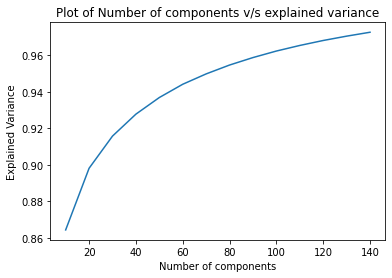

In [ ]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(cooccurrenceMatrix)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

number of components = 10 and explained variance  = 0.8195239710315823
number of components = 20 and explained variance  = 0.86669561692136
number of components = 30 and explained variance  = 0.8921100362566765
number of components = 40 and explained variance  = 0.9084487345632728
number of components = 50 and explained variance  = 0.9203796923981775
number of components = 60 and explained variance  = 0.9296244451544929
number of components = 70 and explained variance  = 0.937021075287111
number of components = 80 and explained variance  = 0.9431780189117214
number of components = 90 and explained variance  = 0.9483716003622326
number of components = 100 and explained variance  = 0.9527262325719262
number of components = 110 and explained variance  = 0.956544738541738
number of components = 120 and explained variance  = 0.9598449708593224
number of components = 130 and explained variance  = 0.9626990396809337
number of components = 140 and explained variance  = 0.965253993953351


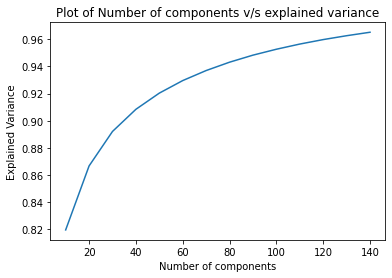

In [149]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
   
    print("number of components = {} and explained variance  = {}".format(dim, svd.explained_variance_ratio_.sum()))
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [153]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
###<your code>###
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix  =  svd.transform(co_matrix)
print(re_co_matrix)

[[ 1.33379734  0.5051592  -0.58124151 ... -0.21633683 -1.02414808
  -0.56481796]
 [ 5.8070454  -0.89396143 -0.09892815 ...  1.84718357  0.60832791
   0.55931141]
 [ 1.48954357 -0.10807789  0.20879066 ...  0.11995805  0.2352351
   0.33102394]
 ...
 [24.05376065 11.36878281 -4.25776002 ...  0.32670015  2.3561586
  -0.20539431]
 [ 8.59168751  3.49044702 -1.94389332 ...  0.2836803   0.96916768
   0.07860021]
 [ 4.13214015 -2.65749414  0.09027243 ... -0.09273382 -0.37367593
  -0.05627222]]


### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [154]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 37 doesn't contain word in vocab_list
u 2 


document 91 doesn't contain word in vocab_list
audrie lousy autocorrect


document 132 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 540 doesn't contain word in vocab_list
beerage 


document 1320 doesn't contain word in vocab_list
ringtoneking 84484


document 2957 doesn't contain word in vocab_list
hanks lotsly 


document 3203 doesn't contain word in vocab_list
k  k   congratulation   


document 3260 doesn't contain word in vocab_list
2 2 146tf150p


document 3390 doesn't contain word in vocab_list
received  understood n acted upon 


document 3730 doesn't contain word in vocab_list
east coast


document 4141 doesn't contain word in vocab_list
garbage bags  eggs  jam  bread  hannaford wheat chex


document 112 doesn't contain word in vocab_list
g w r


document 336 doesn't contain word in vocab_list
   


document 408 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli 



In [155]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing

y_test_filter = np.delete(np.array(y_test), missing_test_list)

test_pred = knn.predict(doc_vec_test)

In [156]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9723346828609987
train acc: 0.9621280432822362
